In [14]:
import numpy as np
import math
# simulate the infected patients number for a specific period T_total
# this function simulate not strictly numbers of X_n in T_total time, given fixed Lambda, P, Alpha
# Random Horizon: means that the whole trajectory stop once X_n hits 0
# @ param N: is the number of total population can be infected
# @ param t_0: a number that is the time when starting the T-time simulation
# @ param x_0: initial infected patients (greater than 0)
# @ param T_total: is total time for this simulation
# @ param maxi_time: is the maximum time that the whole simulation process can go, can be infinity
# @ param H: is the hospital capacity
def simulation_infected(la, p, al, N, t_0, x_0, T_total, H, maxTime):
    # initialize time and infected patient
    # bind variables to the initial conditions
    x_n = x_0
    # make sure the start is not 0
#     assert(x_n!=0)
    # assign initial time to a know value, noted it can start from
    # not just at 0 time
    t_n = t_0
    # introduce T_H := "the total time above the hospital capacity"
    T_H = 0
    # initiate X_n process trajectory and corresponding T_n process
    X_trajectory = []
    T_trajectory = []
    # loop
    # break condition
    # @ condition1: when the time exceeds the maximum time
    # @ condition2: when the infected patients go to zero
    # @ condition3: when the whole populations are infected! :(
    while (t_n<maxTime and
           x_n != 0 and
           x_n < N
          ):
        i = x_n
        # q i _ i+1
        q_forward_i = la*p*2*x_n*(N-i)/(N*(N-1))
        # q i _ i-1
        q_backward_i = al*i
        # waiting time rate v_i = (q i _ i+1) + (q i _ i-1)
        v_i = q_forward_i + q_backward_i
        t_i = np.random.exponential(v_i)
        # calculate T_H before jumping
        if (x_n >= H):
            T_H += t_i
        # jumping probability to STATE i+1 is (q i _ i+1)/v_i
        jump = np.random.binomial(n=1,p=(q_forward_i/v_i))
        if (jump ==1):
            x_n += 1
        elif (jump == 0):
            x_n -= 1            
                        
        # add the jumped X_n at t_i time
        X_trajectory.append(x_n)
        
        # increase time
        T_trajectory.append(t_n+t_i)
        t_n = t_n+t_i
        
        # if hits then zero return
        if (x_n == 0):
            return X_trajectory, T_trajectory, T_H, T_total
        
        # return when the total time of simulation is exceeded
        if ((t_n-t_0) > T_total):
            T = t_n-t_0
            return X_trajectory, T_trajectory, T_H, T
    # also return when the while break condition met
    T = t_n-t_0
    return X_trajectory, T_trajectory, T_H, T

In [28]:
# function takes that updates lambda with negative sign
def update_lambda(_lambda, T_H, T, Beta ,stepsize):
    Y_n = T_H/T
    _lambda -= float(stepsize) * (Y_n-Beta)
    return _lambda

# function that updates p with negative sign
def update_p(_p, T_H, T, Beta, stepsize):
    Y_n = T_H/T
    _p -= float(stepsize) * (Y_n-Beta)
    return _p

# function that updates alpha with positive sign
def update_alpha(_alpha, T_H, T, Beta, stepsize):
    Y_n = T_H/T
    _alpha += float(stepsize) * (Y_n-Beta)
    return _alpha

# @ x_0 initial infected patient
# @ _lambda the inital lambda value
# @ _alpha the inital alpha value
# @ p the inital p value 
# @ C is the hospital capacity 
# @ Beta is the target tracking probability 
# @ K is the batch size of each estimate
# @ The batch is defined here as the total K days of simulation starting from a time point
# @ It is not defined as the number of replications of each simulation with T days
# these are all set arbitary atm
x_0 = 10
_lambda = 0.1
_alpha = 1e-8
_p = 0.9
K = 14
H = 2e4
Beta = 0.05
N = 4e6
maxTime = 3e4                                            
stepsize = [0.0001, 2e-9]


trajectory_lambda = []
trajectory_alpha = []
trajectory_X_n = []
trajectory_T_n = []
# use iteration of 5000 as end of all sequential update
iteration = 0
x_n = x_0
t_n = 0

while iteration < 1000:
    
    # simulate K days of X_n obtain T_H/T, starting from t_0 = 0 and x_0 = x_n
    X_n,T_n,T_H, T = simulation_infected(_lambda,_p,_alpha,N,t_n,x_n,K,H,maxTime)
    
    # use K days simulation to update lambda and alpha
    _alpha = max(0,update_alpha(_alpha,T_H,T,Beta,stepsize[1]))
    _lambda = max(0, update_lambda(_lambda,T_H,T,Beta,stepsize[0]))
    
    # update the objective simulation trajectory
    trajectory_alpha.append(_alpha)
    trajectory_lambda.append(_lambda)
    trajectory_X_n.extend(X_n)
    trajectory_T_n.extend(T_n)
    
    # update x_n and t_n using the last (latest) element of objective simulation X_n and T_n
    x_n = X_n[-1]
    t_n = T_n[-1]
    
    # if x_n is zero, jump up to x_0, restart simulation
    if (x_n==0):
        x_n = x_0
    
    iteration+=1
    

In [26]:
X_n,T_n,T_H, T = simulation_infected(0.098,_p,4e-8,N,0,10,10000,H,maxTime)

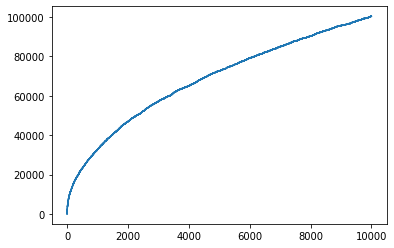

In [27]:
plt.plot(T_n,X_n)

In [7]:
import matplotlib.pyplot as plt

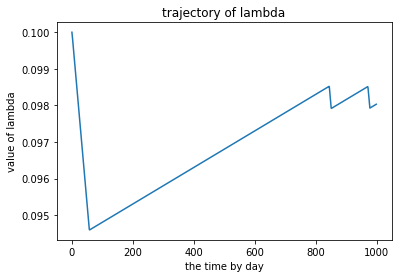

In [29]:
plt.xlabel("the time by day")
plt.ylabel("value of lambda")
plt.title("trajectory of lambda")
plt.plot(trajectory_lambda)
# plt.savefig("trajectory of lambda, experiment1:simulate by 1 day")

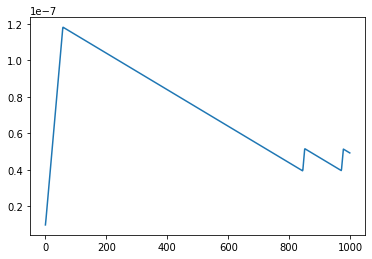

In [30]:
plt.plot(trajectory_alpha)

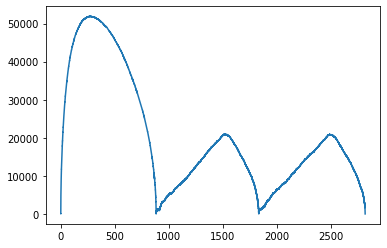

In [31]:
plt.plot(trajectory_T_n,trajectory_X_n)